In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from keras import backend as K
import keras.preprocessing.image as kerasImage
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing.image import img_to_array, load_img
from tensorflow.python.ops import gen_nn_ops
import sys

Using TensorFlow backend.


In [2]:
def get_model_params(model):
    names, activations, weights = [], [], []
    for layer in model.layers:
        name = layer.name if layer.name != 'predictions' else 'fc_out'
        names.append(name)
        activations.append(layer.output)
        weights.append(layer.get_weights())
    return names, activations, weights

def load_image(path,targetSize=(224,224),preprocess=True):
    data = kerasImage.load_img(path,target_size=targetSize)
    if preprocess:
        data = kerasImage.img_to_array(data)
        data = np.expand_dims(data,axis=0)
        data = preprocess_input(data)
    return data

def predict_labels(model, images):
    preds = model.predict(images)
    decoded_preds = decode_predictions(preds)
    labels = [p[0] for p in decoded_preds]
    return labels

def gamma_correction(image, gamma=0.4, minamp=0, maxamp=None):
    c_image = np.zeros_like(image)
    image -= minamp
    if maxamp is None:
        maxamp = np.abs(image).max() + K.epsilon()
    image /= maxamp
    pos_mask = (image > 0)
    neg_mask = (image < 0)
    c_image[pos_mask] = np.power(image[pos_mask], gamma)
    c_image[neg_mask] = -np.power(-image[neg_mask], gamma)
    c_image = c_image * maxamp + minamp
    return c_image

def project_image(image, output_range=(0, 1), absmax=None, input_is_positive_only=False):
    if absmax is None:
        absmax = np.max(np.abs(image), axis=tuple(range(1, len(image.shape))))
    absmax = np.asarray(absmax)
    mask = (absmax != 0)
    if mask.sum() > 0:
        image[mask] /= absmax[mask]
    if not input_is_positive_only:
        image = (image + 1) / 2
    image = image.clip(0, 1)
    projection = output_range[0] + image * (output_range[1] - output_range[0])
    return projection

def reduce_channels(image, axis=-1, op='sum'):
    if op == 'sum':
        return image.sum(axis=axis)
    elif op == 'mean':
        return image.mean(axis=axis)
    elif op == 'absmax':
        pos_max = image.max(axis=axis)
        neg_max = -((-image).max(axis=axis))
        return np.select([pos_max >= neg_max, pos_max < neg_max], [pos_max, neg_max])

def heatmap(image, cmap_type='rainbow', reduce_op='sum', reduce_axis=-1, **kwargs):
    cmap = get_cmap(cmap_type)
    shape = list(image.shape)
    reduced_image = reduce_channels(image, axis=reduce_axis, op=reduce_op)
    projected_image = project_image(reduced_image, **kwargs)
    heatmap = cmap(projected_image.flatten())[:, :3].T
    heatmap = heatmap.T
    shape[reduce_axis] = 3
    return heatmap.reshape(shape)

def get_gammas(img, g=0.4, **kwargs):
    gammas = gamma_correction(img, gamma=g, **kwargs)
    return gammas

def get_heatmaps(gammas, cmap_type='rainbow', **kwargs):
    heatmaps = heatmap(gammas, cmap_type=cmap_type, **kwargs)
    return heatmaps

def visualize_heatmap(image, heatMap, savepath=None):
    fig = plt.figure(figsize=(10,8))
    ax0 = fig.add_subplot(121)
    plt.title('Original')
    ax0.axis('off')
    ax0.imshow(image)
    ax1 = fig.add_subplot(122)
    plt.title('LRP')
    ax1.axis('off')
    ax1.imshow(heatMap, interpolation='bilinear')
    if savepath is not None:
        fig.savefig(savepath)

In [4]:
class LayerwiseRelevancePropagation:
    def __init__(self, alpha=2):
        self.model = VGG16(include_top=True, weights='imagenet')
        self.alpha = alpha
        self.beta = 1 - alpha
        self.names, self.activations, self.weights = get_model_params(self.model)
        self.num_layers = len(self.names)
        self.relevance = self.compute_relevances()
        self.lrp_runner = K.function(inputs=[self.model.input, ], outputs=[self.relevance, ])
    
    def compute_relevances(self):
        r = self.model.output
        for i in range(self.num_layers-2, -1, -1):
            if 'fc' in self.names[i + 1]:
                r = self.backprop_fc(self.weights[i + 1][0], self.weights[i + 1][1], self.activations[i], r)
            elif 'flatten' in self.names[i + 1]:
                r = self.backprop_flatten(self.activations[i], r)
            elif 'pool' in self.names[i + 1]:
                r = self.backprop_max_pool2d(self.activations[i], r)
            elif 'conv' in self.names[i + 1]:
                r = self.backprop_conv2d(self.weights[i + 1][0], self.weights[i + 1][1], self.activations[i], r)
            else:
                raise 'Layer not recognized!'
                sys.exit()
        return r
    
    def backprop_fc(self, w, b, a, r):
        w_p = K.maximum(w, 0.)
        b_p = K.maximum(b, 0.)
        z_p = K.dot(a, w_p) + b_p + K.epsilon()
        s_p = r / z_p
        c_p = K.dot(s_p, K.transpose(w_p))
    
        w_n = K.minimum(w, 0.)
        b_n = K.minimum(b, 0.)
        z_n = K.dot(a, w_n) + b_n - K.epsilon()
        s_n = r / z_n
        c_n = K.dot(s_n, K.transpose(w_n))

        return a * (self.alpha * c_p + self.beta * c_n)
    
    def backprop_flatten(self, a, r):
        shape = a.get_shape().as_list()
        shape[0] = -1
        return K.reshape(r, shape)

    def backprop_max_pool2d(self, a, r, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1)):
        z = K.pool2d(a, pool_size=ksize[1:-1], strides=strides[1:-1], padding='valid', pool_mode='max')

        z_p = K.maximum(z, 0.) + K.epsilon()
        s_p = r / z_p
        c_p = gen_nn_ops.max_pool_grad_v2(a, z_p, s_p, ksize, strides, padding='VALID')

        z_n = K.minimum(z, 0.) - K.epsilon()
        s_n = r / z_n
        c_n = gen_nn_ops.max_pool_grad_v2(a, z_n, s_n, ksize, strides, padding='VALID')

        return a * (self.alpha * c_p + self.beta * c_n)

    def backprop_conv2d(self, w, b, a, r, strides=(1, 1, 1, 1)):
        w_p = K.maximum(w, 0.)
        b_p = K.maximum(b, 0.)
        z_p = K.conv2d(a, kernel=w_p, strides=strides[1:-1], padding='same') + b_p + K.epsilon()
        s_p = r / z_p
        c_p = K.tf.nn.conv2d_backprop_input(K.shape(a), w_p, s_p, strides, padding='SAME')

        w_n = K.minimum(w, 0.)
        b_n = K.minimum(b, 0.)
        z_n = K.conv2d(a, kernel=w_n, strides=strides[1:-1], padding='same') + b_n - K.epsilon()
        s_n = r / z_n
        c_n = K.tf.nn.conv2d_backprop_input(K.shape(a), w_n, s_n, strides, padding='SAME')

        return a * (self.alpha * c_p + self.beta * c_n)
    
    def predict_labels(self, images):
        return predict_labels(self.model, images)

    def run_lrp(self, images):
        print("Running LRP on {0} images...".format(len(images)))
        return self.lrp_runner([images, ])[0]

    def compute_heatmaps(self, images, g=0.2, cmap_type='bwr', **kwargs):
        lrps = self.run_lrp(images)
        print("LRP run successfully...")
        gammas = get_gammas(lrps, g=g, **kwargs)
        print("Gamma Correction completed...")
        heatmaps = get_heatmaps(gammas, cmap_type=cmap_type, **kwargs)
        return heatmaps

In [5]:
fileName = './Data/images/test_5.jpg'
image = load_image(fileName)
lrp = LayerwiseRelevancePropagation()
labels = lrp.predict_labels(image)
print("Labels predicted: ")
print(labels)

Instructions for updating:
Colocations handled automatically by placer.
Labels predicted...


In [6]:
heatMap = lrp.compute_heatmaps(image)
print("Heatmaps generated...")

Running LRP on 1 images...
LRP run successfully...


/Users/paudomingogregorio/Desktop/Projects/TFG/Code/.env/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/Users/paudomingogregorio/Desktop/Projects/TFG/Code/.env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less


Gamma Correction completed...
Heatmaps generated...


/Users/paudomingogregorio/Desktop/Projects/TFG/Code/.env/lib/python3.7/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


DONE


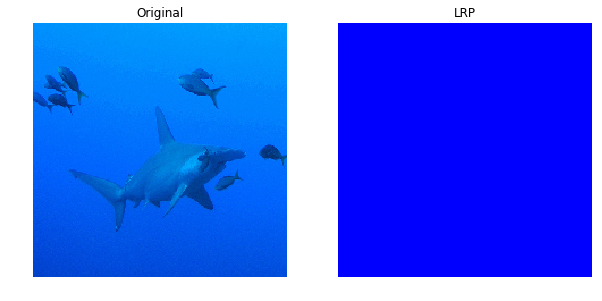

In [7]:
visualize_heatmap(load_image(fileName,preprocess=False), heatMap[0].copy(), savepath='./Results/LRP/Original_TEST5_alpha2.png')
print('DONE')